### Chapter2: Preprocessing(p.45~66)
```
전처리는 데이터 분석에서 매우 중요하다.
결측치 및 이상치 처리, 파생변수 생성, 데이터 불균형 처리 등의 결과에 따라
모델의 성능이 크게 달라질 수 있기 때문이다.
이러한 과정은 많은 시간과 비용이 소요된다.
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%config Completer.use_jedi = False
warnings.filterwarnings('ignore')

In [2]:
#데이터 불러오기
wine = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

In [3]:
# 데이터 기본정보 확인
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Alcohol    178 non-null    float64
 1   Malicacid  178 non-null    float64
 2   Ash        178 non-null    float64
 3   Magnesium  178 non-null    int64  
 4   Hue        178 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 8.3 KB


In [4]:
wine.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

### 결측치 추가
```
결측치가 없으므로 랜덤한 인덱스를 선택하여 결측치를 
임의로 부여한다.
- 결측치 입력변수: Alcohol, Ash
- 결측치 수: 20개
```

In [5]:
df1 = wine.copy()

features = ['Alcohol', 'Ash']

for i in features:
    idx = np.random.choice(df1.index, size=20, replace=False)
    df1.loc[idx, i] = np.nan

print(f'\n 결측치 추가 이후 데이터셋 결측치 \n\n{df1.isna().sum()})')


 결측치 추가 이후 데이터셋 결측치 

Alcohol      20
Malicacid     0
Ash          20
Magnesium     0
Hue           0
dtype: int64)


In [6]:
df1.head(10)

,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.43,127,1.04
1,13.20,1.78,NaN,100,1.05
2,13.16,2.36,2.67,101,1.03
3,14.37,1.95,2.50,113,0.86
4,13.24,2.59,2.87,118,1.04
5,14.20,1.76,NaN,112,1.05
6,14.39,1.87,2.45,96,1.02
7,14.06,2.15,2.61,121,1.06
8,14.83,1.64,2.17,97,1.08
9,13.86,1.35,2.27,98,1.01


```
이제 시각화를 통해 결측치를 확인해본다.
```

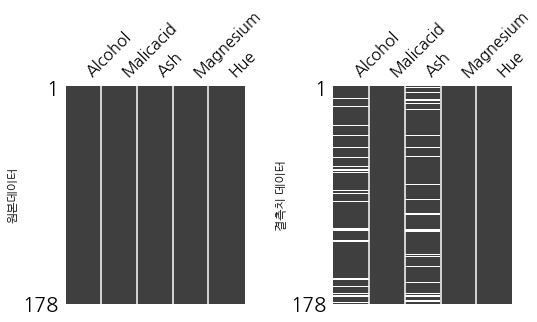

In [7]:
import koreanize_matplotlib

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False #문자깨짐 방지

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)

import missingno as miso

miso.matrix(df=wine, ax=ax[0], sparkline=False)
miso.matrix(df=df1, ax=ax[1], sparkline=False)

ax[0].set_ylabel('원본데이터')
ax[1].set_ylabel('결측치 데이터')
plt.show()

```
오른쪽 그래프를 통해 2개 feature에 결측치가 일부 추가된 것을
확인할 수 있다.
```

### Imputation
- Zero Imputation: 결측치를 0으로 대체
- Constant: 결측치를 특정 값으로 대체
- 대푯값 대체(평균, 중앙값, 최빈)
- 단순확률 대치법1(Hot-deck): 현재 데이터 중 비슷한 성향의 데이터로 대체(랜덤)
- 단순확률 대치법2(Cold-deck): 외부, 이전 데이터에서 대체자료 가져와서 대체
 (여기서는 hot-deck 방식으로 wine에서 랜덤샘플링으로 대체)
- 모델링 방식으로 대체(KNN, linear 등)

In [8]:
# 1. Zero imputation
imp1 = df1.fillna(0)

# 2. Constant imputation
imp2 = df1.fillna(1000)

print(f'< Result of Zero Imputation >\n\n{imp1.head(10)}')
print(f'\n< Result of Constant Imputation >\n\n{imp2.head(10)}')

< Result of Zero Imputation >

   Alcohol  Malicacid   Ash  Magnesium   Hue
0    14.23       1.71  2.43        127  1.04
1    13.20       1.78  0.00        100  1.05
2    13.16       2.36  2.67        101  1.03
3    14.37       1.95  2.50        113  0.86
4    13.24       2.59  2.87        118  1.04
5    14.20       1.76  0.00        112  1.05
6    14.39       1.87  2.45         96  1.02
7    14.06       2.15  2.61        121  1.06
8    14.83       1.64  2.17         97  1.08
9    13.86       1.35  2.27         98  1.01

< Result of Constant Imputation >

   Alcohol  Malicacid      Ash  Magnesium   Hue
0    14.23       1.71     2.43        127  1.04
1    13.20       1.78  1000.00        100  1.05
2    13.16       2.36     2.67        101  1.03
3    14.37       1.95     2.50        113  0.86
4    13.24       2.59     2.87        118  1.04
5    14.20       1.76  1000.00        112  1.05
6    14.39       1.87     2.45         96  1.02
7    14.06       2.15     2.61        121  1.06
8    1

In [9]:
# mean 대체
from sklearn.impute import SimpleImputer
# strategy: mean, median, most_frequent
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imp3 = pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns)

print(f'Alcohol mean: {df1.Alcohol.mean()}\nAsh mean: {df1.Ash.mean()}')
imp3.head(10)

Alcohol mean: 13.01481012658228
Ash mean: 2.369873417721519


,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.430000,127.0,1.04
1,13.20,1.78,2.369873,100.0,1.05
2,13.16,2.36,2.670000,101.0,1.03
3,14.37,1.95,2.500000,113.0,0.86
4,13.24,2.59,2.870000,118.0,1.04
5,14.20,1.76,2.369873,112.0,1.05
6,14.39,1.87,2.450000,96.0,1.02
7,14.06,2.15,2.610000,121.0,1.06
8,14.83,1.64,2.170000,97.0,1.08
9,13.86,1.35,2.270000,98.0,1.01


In [10]:
# 단순확률 대치법: 여기서는 hot-deck
imp4 = df1.copy()

for x in features:
    null_idx = imp4[imp4[x].isna()].index
    samples = wine[x].sample(len(null_idx))
    imp4.loc[null_idx, x] = samples.values
    print(f'\nfeature: {x}')
    print(pd.DataFrame({'null_index':null_idx.values, '대체값':samples.values}))
    


feature: Alcohol
    null_index    대체값
0           10  12.08
1           16  14.34
2           32  13.11
3           40  12.58
4           50  12.70
5           58  13.84
6           65  12.16
7           68  12.21
8           70  13.83
9           85  12.07
10          87  12.34
11          94  13.32
12         116  12.51
13         117  11.76
14         126  13.30
15         157  12.17
16         163  13.64
17         169  12.29
18         171  12.37
19         176  13.49

feature: Ash
    null_index   대체값
0            1  2.92
1            5  2.16
2           11  2.30
3           14  2.24
4           19  2.54
5           40  2.28
6           50  2.58
7           57  1.98
8           80  2.27
9           92  2.32
10         104  2.41
11         117  2.20
12         118  2.48
13         137  2.31
14         139  2.61
15         147  2.14
16         160  1.90
17         169  2.48
18         171  2.61
19         175  2.39


In [11]:
imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [12]:
# 모델링 기법으로 보간(KNN, linear)

from sklearn.impute import KNNImputer

imputer2 = KNNImputer(n_neighbors=3)

imp5 = pd.DataFrame(imputer2.fit_transform(df1), columns=df1.columns)

print(f'< KNN Imputer > \n{imp5.isna().sum()}')

# linear
imp6 = df1.interpolate(method='linear') #cubic ...
print(f'\n< linear >\n{imp6.isna().sum()}')


< KNN Imputer > 
Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

< linear >
Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64


### 각 보간기법 평가
- 평가척도: MSE, MAE
- 기준 데이터셋: WINE
- 데이터셋:
<pre>
1.imp1: zero 대체
2.imp3: 평균 대체
3.imp4: hot-deck
4.imp5: KNN Imputer
5.imp6: 선형보간
</pre>

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def p_evaluation(f):
    df_list = [wine[f], imp1[f], imp3[f], imp4[f], imp5[f], imp6[f]]
    df_name = ['real', 'zero', 'mean', 'hot-deck', 'knn', 'linear']
    
    report = pd.concat(df_list, axis=1)
    report.columns = df_name
    score_report = pd.DataFrame(index=['MAE', 'MSE'])
    
    for col in df_name:
        mae = mean_absolute_error(report['real'], report[col])
        mse = mean_squared_error(report['real'], report[col])
        score_report.loc['MAE', col] = mae
        score_report.loc['MSE', col] = mse
    return score_report


result = []
for f in features:
    print(f'< {f} >')        
    print(p_evaluation(f).T, '\n')
    result.append(p_evaluation(f).T)

< Alcohol >
               MAE        MSE
real      0.000000   0.000000
zero      1.448146  18.728477
mean      0.072470   0.065839
hot-deck  0.084045   0.093409
knn       0.061966   0.051622
linear    0.060674   0.048217 

< Ash >
               MAE       MSE
real      0.000000  0.000000
zero      0.262921  0.621849
mean      0.022583  0.006714
hot-deck  0.032472  0.015348
knn       0.020318  0.005379
linear    0.021423  0.005586 



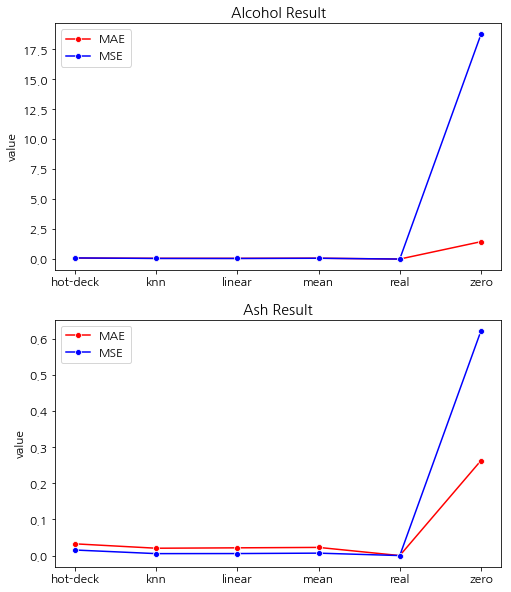

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

for i in range(len(result)):
    sns.lineplot(data=result[i], x=result[i].index, y='MAE', ax=ax[i], color='red', marker='o', label='MAE')
    sns.lineplot(data=result[i], x=result[i].index, y='MSE', ax=ax[i], color='blue', marker='o', label='MSE')
    ax[i].set_title(f'{features[i]} Result')
    ax[i].set_ylabel('value')

```
Alcohol은 선형보간이, Ash는 평균 보간이 가장 성능이 좋음
```

### 이상치 처리
- ESD: 평균 - 3*표준편차 < normal data < 평균 + 3*표준편차
- 기하평균 +- 2.5*표준편차 미만/초과
- Q1 - 1.5*IQR < normal data < Q3 + 1.5*IQR *
- 군집분석을 통한 진단: DBSCAN 등

In [15]:
# 이상치 찾기: 사분위수 이용
IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + 1.5*IQR
down = wine['Malicacid'].quantile(0.25) - 1.5*IQR
print(f'IQR은 {IQR}')
print(f'상한선은 {top:.2f}')
print(f'하한선은 {down:.2f}')

IQR은 1.48
상한선은 5.30
하한선은 -0.62


In [1]:
out_dt = wine[(wine['Malicacid']>top) | (wine['Malicacid']<down)]
out_dt

NameError: name 'wine' is not defined

In [17]:
out_dt.index

Int64Index([123, 137, 173], dtype='int64')

In [18]:
# 이상치 절단
drop_dt = wine['Malicacid'].drop(out_dt.index.values, axis=0)

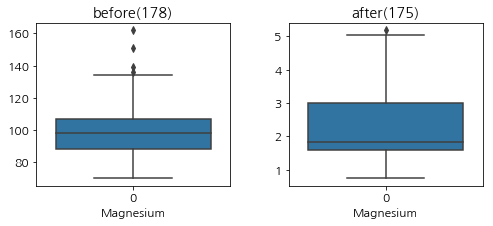

In [19]:
# 시각화
t_name = ['before', 'after']
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for i, dt in enumerate([wine['Magnesium'], drop_dt]):
    sns.boxplot(data=dt, ax=ax[i])
    ax[i].set_title(f'{t_name[i]}({len(dt)})')
    ax[i].set_xlabel('Magnesium')
    plt.subplots_adjust(wspace=0.3)
plt.show()

```
절단을 통해 대다수의 이상치는 제거되었지만, 분포가 달라지므로
새로운 이상치가 생기기도 한다.
```

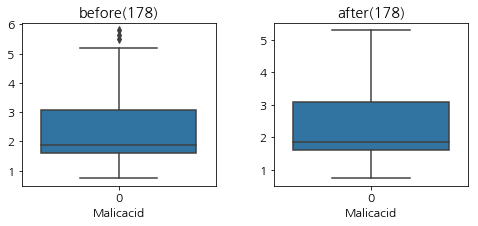

In [20]:
# 조정
aj_df = wine['Malicacid'].clip(down, top)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, dt in enumerate([wine['Malicacid'], aj_df]):
    sns.boxplot(data=dt, ax=ax[i])
    ax[i].set_title(f'{t_name[i]}({len(dt)})')
    ax[i].set_xlabel('Malicacid')
    plt.subplots_adjust(wspace=0.3)
    
plt.show()

```
이상치를 삭제하지 않고 상한치와 하한치의 값으로 대체
이렇게 하면 데이터의 소실이 없이 이상치를 제거할 수 있다.
```

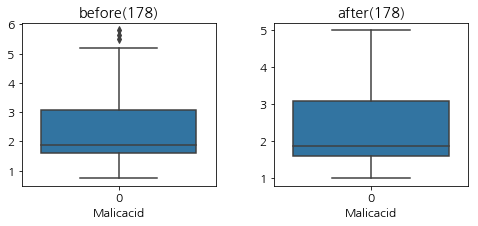

In [21]:
#클리핑
aj_df2 = wine['Malicacid'].clip(1, 5)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, dt in enumerate([wine['Malicacid'], aj_df2]):
    sns.boxplot(data=dt, ax=ax[i])
    ax[i].set_title(f'{t_name[i]}({len(dt)})')
    ax[i].set_xlabel('Malicacid')
    plt.subplots_adjust(wspace=0.3)
    
plt.show()

```
이전의 방법과 유사하나, 특정 값으로 대체한다는 것이 다르다.
데이터에 대해 확실한 정보를 알고 있을 때 사용한다.
```

### 클래스 불균형
```
실세계의 데이터는 대체로 불균형하다. 
경우에 따라서는 극단적으로 불균형한 데이터가 있을 수 있으며, 
이를 잘 처리해야 의도하는 결과를 도출할 수 있다.
```
- Oversampling: 소수 클래스의 데이터수를 늘림 *
 - SMOTE, RandomOversampling, BorderlineSMOTE, 
 - KMeansSMOTE, SVMSMOTE, ADASYN
- Undersampling: 다수 클래스의 데이터수를 줄임
 - RandomUndersampler, ClusterCentroids, 
 - CondensedNearstNeighbour, AIIKNN

In [22]:
from sklearn.datasets import load_breast_cancer

c_dt = load_breast_cancer()

c_dt = pd.DataFrame(np.c_[c_dt['data'], c_dt['target']], columns= list(c_dt['feature_names'])+['target'])


c_dt = c_dt[['mean radius', 'mean texture', 'mean area', 'target']]

display(c_dt.head(3))

print(f"원본데이터의 클래스 분포: \n{c_dt['target'].value_counts()}")
      
# 불균형 클래스 셋팅
dd1 = c_dt[c_dt['target']==0].sample(50)
dd2 = c_dt[c_dt['target']==1].sample(250)
ib_dt = pd.concat([dd1, dd2], axis=0)
display(ib_dt.head(3))

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}")


,mean radius,mean texture,mean area,target
0,17.99,10.38,1001.0,0.0
1,20.57,17.77,1326.0,0.0
2,19.69,21.25,1203.0,0.0


원본데이터의 클래스 분포: 
1.0    357
0.0    212
Name: target, dtype: int64


,mean radius,mean texture,mean area,target
274,17.93,24.48,998.9,0.0
433,18.82,21.97,1110.0,0.0
180,27.22,21.87,2250.0,0.0


불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64


Using TensorFlow backend.


불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64
오버샘플링 데이터의 클래스 분포: 
1.0    250
0.0    250
Name: target, dtype: int64


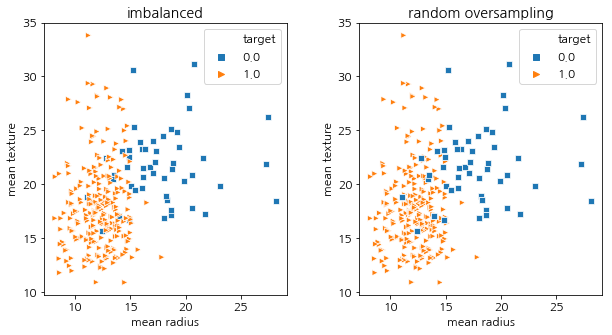

In [23]:
# 랜덤오버샘플링
# !pip install imblearn
feat = ib_dt.drop('target', axis=1)
target = ib_dt['target']

from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=42)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt0 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}")
print(f"오버샘플링 데이터의 클래스 분포: \n{bal_dt0['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'random oversampling']

for i, dt in enumerate([ib_dt, bal_dt0]):
    sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
    ax[i].set_title(t_list[i])
plt.subplots_adjust(wspace=0.3)
plt.show()    

랜덤오버샘플링은 말 그대로 소수 클래스의 값을 랜덤하게 복사하여 증강시켜 클래스가 불균형하지 않도록
맞춰주는 기법이다. 

위와 같이 분포의 변화는 없으나 소수클래스의 데이터가 많아지면서 해당 클래스에 대한
가중치가 높아지게 된다. 

또한 단순히 기존 데이터를 그대로 복사한 것이기 때문에 과적합이 될 수 있다.

불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

SMOTE 데이터의 클래스 분포: 
1.0    250
0.0    250
Name: target, dtype: int64


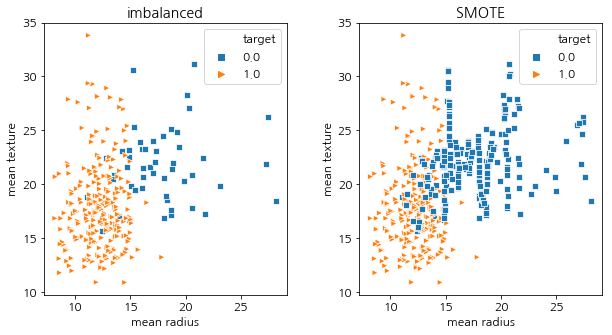

In [24]:
#smote 
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=42, k_neighbors=3)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt1 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"SMOTE 데이터의 클래스 분포: \n{bal_dt1['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'SMOTE']

for i, dt in enumerate([ib_dt, bal_dt1]):
    sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
    ax[i].set_title(t_list[i])
plt.subplots_adjust(wspace=0.3)
plt.show()    

```
위 방식은 임의의 소수 클래스에서 데이터를 샘플링 한 후 k개로 지정된 인근 소수클래스 데이터를 찾은 후
이 k개의 이웃 중 임의의 데이터를 랜덤선택 후 X 사이에 새로운 데이터 x'를 생성한다.
```
$$
x_{\text{new}} = x_i + \delta \cdot (x_{zi} - x_i)
$$

- $ x_i: 소수 클래스의 원본 샘플 $
- $ x_{zi}: x_i 의 k-최근접 이웃 중 하나 (무작위 선택)$  
- $ \delta : 0과 1 사이의 임의의 실수  $
- $ x_{\text{new}} : 새롭게 생성된 합성 샘플 $




불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

BorderlineSMOTE 데이터의 클래스 분포: 
1.0    250
0.0    250
Name: target, dtype: int64


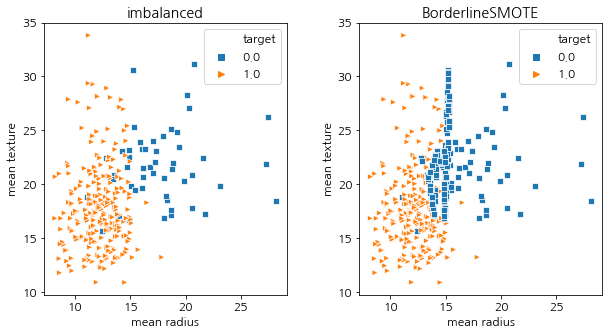

In [25]:
#Border smote
from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=42, k_neighbors=3)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt2 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"BorderlineSMOTE 데이터의 클래스 분포: \n{bal_dt2['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'BorderlineSMOTE']

for i, dt in enumerate([ib_dt, bal_dt2]):
    sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
    ax[i].set_title(t_list[i])
plt.subplots_adjust(wspace=0.3)
plt.show()    

```
또 다른 SMOTE 의 변형으로 각 클래스 분류경계에 인접한 소수클래스 데이터를 대상으로 
SMOTE를 적용한다. SMOTE와 공식은 동일하다.
```
$$
x_{\text{new}} = x_i + \delta \cdot (x_{zi} - x_i)
$$

- $ x_i: 경계에 위치한 소수 클래스의 원본 샘플 $
- $ x_{zi}: x_i 의 k-최근접 이웃 중 하나 (무작위 선택)$  
- $ \delta : 0과 1 사이의 임의의 실수  $
- $ x_{\text{new}} : 새롭게 생성된 합성 샘플 $



불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

KMEANS SMOTE 데이터의 클래스 분포: 
0.0    251
1.0    250
Name: target, dtype: int64


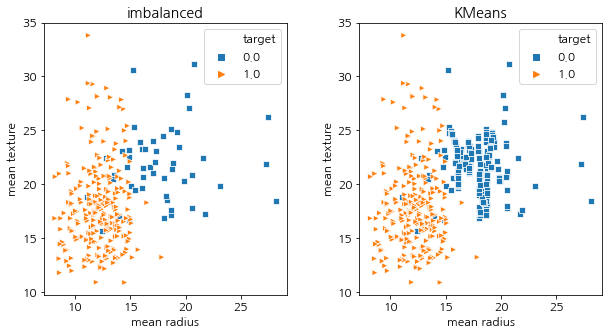

In [26]:
# kmeans smote
from imblearn.over_sampling import KMeansSMOTE
os = KMeansSMOTE(random_state=42, k_neighbors=3)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt3 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"KMEANS SMOTE 데이터의 클래스 분포: \n{bal_dt3['target'].value_counts()}")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'KMeans']

for i, dt in enumerate([ib_dt, bal_dt3]):
    sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
    ax[i].set_title(t_list[i])
plt.subplots_adjust(wspace=0.3)
plt.show()    


```
또 다른 SMOTE 의 변형으로 kmeans의 클러스터링 알고리즘을 사용하여 전체 클래스를 클러스터링하고
소수 클래스 샘플이 적게 포함된 군집에 소수 클래스 샘플을 추가하는 방법이다.
KMeans 클러스터링으로 소스 클래스 샘플 판별 후는 SMOTE와 동일한 공식 사용
```
<절차>
1. 전체 데이터를 KMeans로 클러스터링

2. 각 클러스터의 소수 클래스 비율 계산

3. 소수 클래스 비율이 높거나 균형에 가까운 클러스터를 선택

4. 선택된 클러스터 내에서만 SMOTE 적용 → 새로운 샘플 생성

5. 모든 클러스터에 대해 반복 후 데이터 결합


불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

SVM SMOTE 데이터의 클래스 분포: 
1.0    250
0.0    250
Name: target, dtype: int64


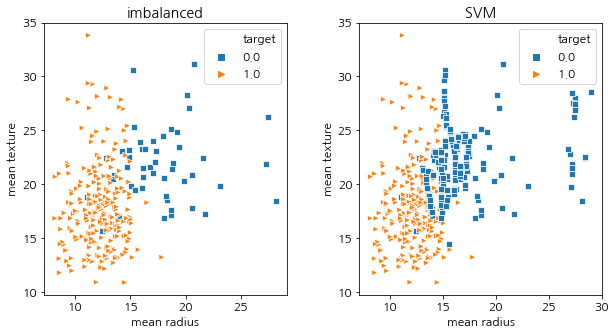

In [27]:
#svm smote
from imblearn.over_sampling import SVMSMOTE
os = SVMSMOTE(random_state=42, k_neighbors=3)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt4 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)


print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"SVM SMOTE 데이터의 클래스 분포: \n{bal_dt4['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'SVM']

for i, dt in enumerate([ib_dt, bal_dt4]):
      sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
      ax[i].set_title(t_list[i])

plt.subplots_adjust(wspace=0.3)
plt.show()

```
또 다른 SMOTE 의 변형으로 SVM 알고리즘의 supporter vector를 활용하며 소수 클래스인 support vector 
데이터들을 경계 데이터로 삼아 SMOTE를 적용한다.
```
<절차>
1. SVM 모델 학습
 - 원본 데이터에 대해 SVM을 학습시킨다.
   이때 클래스 간 분리를 위한 **초평면(hyperplane)**을 찾음

2. Support Vector 추출
 - 소수 클래스 중 SVM에서 경계면 가까이에 위치한 Support Vector만 선택


3. K-최근접 이웃 선택
 - 선택된 Support Vector 주변의 소수 클래스 샘플 중 K개의 이웃을 찾기

4. Synthetic sample 생성
 - 일반 SMOTE처럼, 이웃과의 선형 보간을 통해 새로운 샘플을 생성

공식은 일반 SMOTE와 동일

불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

ADASYN 데이터의 클래스 분포: 
0.0    251
1.0    250
Name: target, dtype: int64


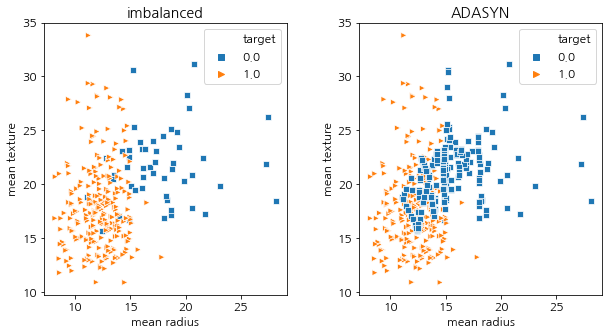

In [28]:
#adasyn

from imblearn.over_sampling import ADASYN

os = ADASYN(random_state=42, n_neighbors=3)
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt5 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"ADASYN 데이터의 클래스 분포: \n{bal_dt5['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'ADASYN']

for i, dt in enumerate([ib_dt, bal_dt5]):
      sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
      ax[i].set_title(t_list[i])

plt.subplots_adjust(wspace=0.3)
plt.show()


# adasyn
```
가중치를 통해 SMOTE를 적용시키는 방법으로 인접한 데이터의 소수클래스와 다수클래스의 비율에 따라
생성되는 샘플의 개수가 정해진다. 즉, 생성되는 샘플의 개수는 소수 클래스의 밀도에 반비례함


```
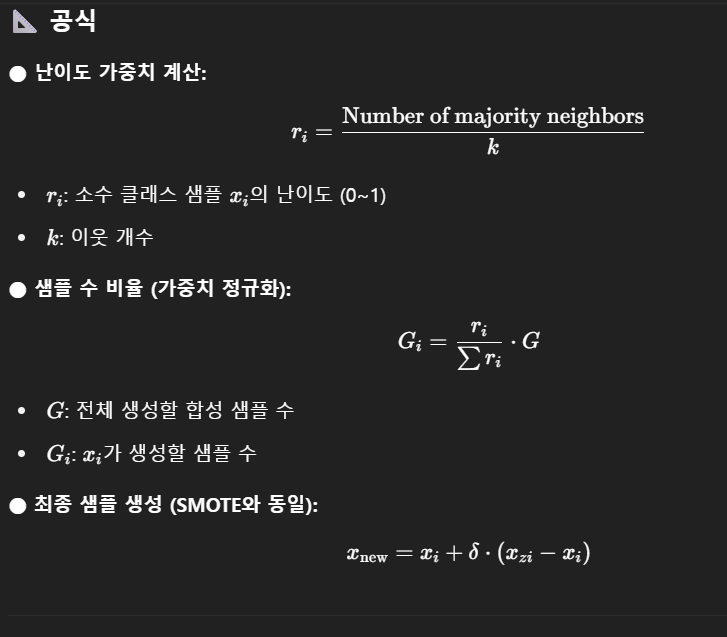

불균형 데이터의 클래스 분포: 
1.0    250
0.0     50
Name: target, dtype: int64

언더샘플링[ClusterCentroids] 데이터의 클래스 분포: 
1.0    50
0.0    50
Name: target, dtype: int64


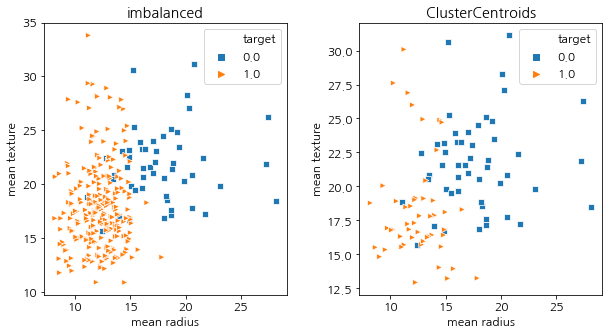

In [29]:
#clusterCentroids

from imblearn.under_sampling import ClusterCentroids

os = ClusterCentroids(random_state=42, sampling_strategy='auto')
bal_feat, bal_target = os.fit_resample(feat, target)

bal_dt6 = pd.DataFrame(np.c_[bal_feat, bal_target], columns=ib_dt.columns)

print(f"불균형 데이터의 클래스 분포: \n{ib_dt['target'].value_counts()}\n")
print(f"언더샘플링[ClusterCentroids] 데이터의 클래스 분포: \n{bal_dt6['target'].value_counts()}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

t_list = ['imbalanced', 'ClusterCentroids']

for i, dt in enumerate([ib_dt, bal_dt6]):
      sns.scatterplot(data=dt, x='mean radius', y='mean texture', hue='target', ax=ax[i], style='target', markers=['s', '>'])
      ax[i].set_title(t_list[i])

plt.subplots_adjust(wspace=0.3)
plt.show()

## ✅ 오버샘플링 기법 요약표

| 기법                      | 개념                                 | 공식                                         | 장점             | 단점               | 사용 예                 |
| ----------------------- | ---------------------------------- | ------------------------------------------ | -------------- | ---------------- | -------------------- |
| **Random OverSampling** | 소수 클래스 샘플을 단순 복제하여 균형을 맞춤          | -                                          | 구현 간단, 빠름      | 과적합 가능성 ↑        | 불균형이 매우 심하지 않은 경우    |
| **SMOTE**               | 소수 클래스 샘플과 이웃 간 선형 보간으로 합성 샘플 생성   | $x_{new} = x_i + \delta (x_{zi} - x_i)$    | 과적합 ↓, 일반화 ↑   | 경계 근처 노이즈 증식 위험  | 기본 불균형 문제 해결에 널리 사용  |
| **BorderlineSMOTE**     | 경계에 가까운 소수 클래스에 집중하여 샘플 생성         | 위 공식 사용, 경계 샘플만 선택                         | 경계 학습 강화       | 노이즈에 민감          | 경계에 있는 소수 클래스가 중요할 때 |
| **KMeansSMOTE**         | KMeans로 클러스터링 후, 클러스터 내에서 SMOTE 적용 | 위 SMOTE 공식 + 클러스터 선택 기준                    | 노이즈 적고 효과적 샘플링 | 복잡도 ↑, 파라미터 많음   | 데이터 분포가 복잡한 경우       |
| **SVMSMOTE**            | SVM으로 결정경계를 학습하고 경계 근처에서 SMOTE 수행  | $x_{new} = x_i + \delta (x_{svm} - x_i)$   | 경계 학습 극대화      | 느릴 수 있음, 파라미터 많음 | 경계에 집중해야 하는 분류문제     |
| **ADASYN**              | 어려운 샘플에 더 많은 합성 샘플 생성 (오류 중심)      | 클래스 별 $G_i = \frac{r_i}{\sum r_j} \cdot G$ | 학습 곤란 샘플 보완    | 과도한 샘플링 가능성      | 경계 샘플 학습 강화 필요 시     |

## ✅ 언더샘플링 기법 요약표

| 기법                                  | 개념                                | 공식                 | 장점            | 단점              | 사용 예               |
| ----------------------------------- | --------------------------------- | ------------------ | ------------- | --------------- | ------------------ |
| **Random UnderSampling**            | 다수 클래스 샘플을 임의로 제거                 | -                  | 단순, 속도 빠름     | 정보 손실, 불안정      | 소수 클래스가 충분히 있을 때   |
| **ClusterCentroids**                | 다수 클래스 샘플을 KMeans로 클러스터링 → 중심만 사용 | KMeans 중심점 $\mu_k$ | 대표성 ↑, 노이즈 제거 | 소수 클래스 정보 손실 우려 | 고차원/복잡 데이터 요약      |
| **CondensedNearestNeighbour (CNN)** | 결정경계 유지에 필요한 샘플만 남김               | 최근접 이웃 기반 유지       | 결정경계 보존       | 느림, 구현 복잡       | 결정경계가 중요할 때        |
| **AllKNN**                          | 여러 K값으로 CNN 반복 → 샘플 안정화           | 여러 CNN 반복          | 과소적합 방지       | 속도 느림           | 노이즈 제거 + 경계 유지 필요시 |

---


## 모델평가: 로지스틱 회귀 모델링
- 평가지표: Accuracy, F1 score

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

dt_lists = [ib_dt, bal_dt0, bal_dt1, bal_dt2, bal_dt3, bal_dt4, bal_dt5, bal_dt6]
dt_titles = ['샘플링 미시행', 'random_over_sampling', 'SMOTE', 'Borderline_SMOTE', 'KMeans_SMOTE', 'SVM_SMOTE', 'ADASYS' , 'ClusterCentroids']

score_list = pd.DataFrame(index=['Train_acc', 'Test_acc', 'Train_F1', 'Test_F1'], columns=dt_titles)

for dt, title in zip(dt_lists, dt_titles):
    target = dt['target']
    feats = dt.drop('target', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(feats, target)
    lr = LogisticRegression(max_iter=300)
    lr.fit(x_train, y_train)
    train_pred = lr.predict(x_train)
    test_pred = lr.predict(x_test)
    score_list.loc['Train_acc', title] = accuracy_score(y_train, train_pred)
    score_list.loc['Test_acc', title] = accuracy_score(y_test, test_pred)
    score_list.loc['Train_F1', title] = f1_score(y_train, train_pred)
    score_list.loc['Test_F1', title] = f1_score(y_test, test_pred)
    
display(score_list)
    

,샘플링 미시행,random_over_sampling,SMOTE,Borderline_SMOTE,KMeans_SMOTE,SVM_SMOTE,ADASYS,ClusterCentroids
Train_acc,0.942222,0.909333,0.88,0.824,0.957333,0.877333,0.778667,0.88
Test_acc,0.973333,0.88,0.904,0.776,0.97619,0.864,0.777778,0.88
Train_F1,0.967254,0.909574,0.884319,0.829897,0.958333,0.879581,0.787724,0.88
Test_F1,0.982456,0.888889,0.904762,0.777778,0.974359,0.859504,0.777778,0.888889


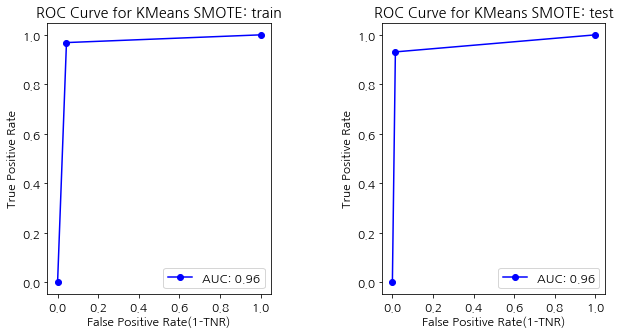

In [31]:
# kmeans smote의 roc courve
from sklearn.metrics import roc_curve, auc

target = bal_dt3['target']
feats = bal_dt3.drop('target', axis=1)
x_train, x_test, y_train, y_test = train_test_split(feats, target)
lr = LogisticRegression(max_iter=300)
lr.fit(x_train, y_train)
train_pred = lr.predict(x_train)
test_pred = lr.predict(x_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
i = 0
title = ['train', 'test']
for real, pred in zip([y_train, y_test], [train_pred, test_pred]):
    FPR, TPR, thresholds = roc_curve(real, pred)
    roc_auc_score = auc(FPR, TPR)
    
    ax[i].plot(FPR, TPR, color='blue', label=f'AUC: {roc_auc_score:.2f}', marker='o')
    ax[i].set_xlabel('False Positive Rate(1-TNR)')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(f'ROC Curve for KMeans SMOTE: {title[i]}')
    ax[i].legend(loc='lower right')
    i += 1
plt.subplots_adjust(wspace=0.5)
    
    

```
모델평가 결과, kmeans smote가 acc, f1 기준으로도 좋은 성능을 내는 것을 알 수 있다.
반면, adasys의 성능이 오버샘플링 중 가장 낮았다.
다운 샘플링의 경우 성능도 좋지 않지만, 데이터 수가 많지 않은 데이터 셋에서 데이터 수를 줄이는 것은 적절하지 않다.
```